Multi-Layer perceptron for parabolic dynamics prediction
---------------

This notebook loads the data generated from the pre-processing notebook and uses them to train and test a multi-layer perceptron for predicting the three parabolic coefficients that approximate the dynamics of the datasets melodic motifs.

This model and the results obtained are reported in:

    Ortega, F.J.M., Perez, A., Ramirez, R. Predicting dynamics in violin pieces with features from melodic motifs. In: Proceedings of the 12th International Workshop on Machine Learning and Music (MML2019). Würzburg, Germany. 2019.

#### Load and preprocess training data

In [1]:
import numpy as np
import arff

np.random.seed(1728)

def filter_outliers(arr, outlier_factor=3.):
    insts, feats = arr.shape
    outs = [True] * insts
    for i in range(0, feats):
        if dataset['attributes'][i][1] == 'REAL':
            q1, q3 = np.percentile(arr[:,i], [25, 75], interpolation='lower')
            iqr = q3 - q1
            # print('lower: {lw}; upper: {up}'.format(lw=q1 - outlier_factor * iqr, up=q3 + outlier_factor * iqr))
            outs = np.all([outs, arr[:,i] >= (q1 - outlier_factor * iqr)], axis=0)
            outs = np.all([outs, arr[:,i] <= (q3 + outlier_factor * iqr)], axis=0)
    return outs

def toOneHot(arr, index, nom_vals):
    if len(nom_vals) > 2:
        rows, cols = arr.shape
        newarr = np.zeros((rows, cols+len(nom_vals)-1), dtype=object)
        #print('oneHot: index=' + str(index) + '; vals=' + str(nom_vals))
        for _ in range(len(nom_vals)-1):
            dataset['attributes'].insert(index,(dataset['attributes'][index]))
        newarr[:,0:index] = arr[:,0:index]
        newarr[:,index+len(nom_vals):] = arr[:,index+1:]
        for i in range(0,len(nom_vals)):
            newarr[arr[:,index] == nom_vals[i],index+i] = 1
        return newarr
    else:
        aux = np.zeros((arr.shape[0],1))
        aux[arr[:,index] == nom_vals[0], 0] = 1
        arr[:,index] = aux[:,0]
        return arr

    
#  read arff
fhandle = open('data/allviolin.arff', 'r')
dataset = arff.load(fhandle)
arr = np.asarray(dataset['data'])
print('initial size: ' + str(len(arr)))

#  filter by motif size
arr = arr[np.array(arr[:,2], dtype=int) > 3, :]
print('size after small motif crop: ' + str(len(arr)))

#  one-hot encode nominal values
#print(arr[0])
rows, cols = arr.shape
i = 0
while i < cols:
    if isinstance(dataset['attributes'][i][1], list):
        arr = toOneHot(arr, i, dataset['attributes'][i][1])
        rows, cols = arr.shape
        if len(dataset['attributes'][i][1]) > 2:
            i = i + len(dataset['attributes'][i][1]) - 1
    i = i + 1
#print(arr[0])

# numpy array ready to be cast as numeric
arr = arr.astype(np.dtype('f8'))

#  remove unused attributes
rows, cols = arr.shape
newarr = np.empty((rows,cols-2), dtype=np.dtype('f8'))
newarr[:,:-3] = arr[:,:-5]
newarr[:,-3:] = arr[:,-3:]
dataset['attributes'].pop(-4)
dataset['attributes'].pop(-4)
idcols = arr[:,-5:-3].astype(int)
arr = newarr

#  filter outliers/extreme values
filtered = filter_outliers(arr)
arr = arr[filtered,:]
idcols = idcols[filtered,:]
print('size w/o outliers: ' + str(len(arr)))

print('after filtering outliers')
lvls = np.load('data/levels/' + str(idcols[123,0]) + 'lvls.npy')
lvls = lvls[idcols[123,1]][0]
x = np.linspace(0, 1, len(lvls))
coefs = np.polyfit(x, lvls, 2)
print(coefs)
print(arr[123,-3:])

#  standardize features
rows, cols = arr.shape

moments = np.zeros((3,2)) # output mean and std for reverting predictions
moments[:,0] = np.mean(arr[:,-3:], axis=0)
moments[:,1] = np.std(arr[:,-3:], ddof=1, axis=0)
for i in range(cols):
    if dataset['attributes'][i][1] == 'REAL':
        arr[:,i] = (arr[:,i] - np.mean(arr[:,i])) / np.std(arr[:,i], ddof=1)
        
        
#  shuffle and split train/xval/test
shuffler = np.array(list(range(0,rows)))
np.random.shuffle(shuffler)
arr = arr[shuffler,:]
idcols = idcols[shuffler,:]
train = arr[:(rows*9)//10,:]
#xval = arr[(rows*3)//5:(rows*4)//5,:]
test = arr[(rows*9)//10:,:]

#print('lengths: {tr}, {x}, {t}'.format(tr=len(train), x=len(xval), t=len(test)))
print('lengths: {tr}, {t}'.format(tr=len(train), t=len(test)))


initial size: 12749
size after small motif crop: 10814
size w/o outliers: 8099
after filtering outliers
[ -4.82207241  11.16700697 -32.03978684]
[ -4.8221  11.167  -32.0398]
lengths: 7289, 810


#### Define the neural network

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1728)
_, attrs = arr.shape
attrs = attrs - 3 # 3 outputs
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(attrs, attrs//2 + 1)
        self.fc2 = nn.Linear(attrs//2 + 1, attrs//2 + 1)
        self.fc3 = nn.Linear(attrs//2 + 1, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(net.parameters(), lr=0.2, momentum=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

#### Train the model

In [ ]:
epochs = 3000
batch_size = 100

for t in range(epochs):
    np.random.shuffle(train)
    input_dt = torch.Tensor(train[:,:-3])
    truth = torch.Tensor(train[:,-3:])
    i = 0
    accloss = []
    accR = []
    while i < len(input_dt):
        if (i + batch_size < len(input_dt)):
            x = input_dt[i:i + batch_size,:]
            y = truth[i:i + batch_size,:]
        else:
            x = input_dt[i:,:]
            y = truth[i:,:]
        i = i + batch_size
        out = net(x)
        loss = loss_fn(out, y)
        net.zero_grad()
        loss.backward()
        optimizer.step()
        pred = out.detach().numpy()
        accloss.append(loss.item())
        accR.append(np.corrcoef(pred[:,0], y[:,0])[0,1])
    print('epoch: ' + str(t) + ' loss: ' + str(np.mean(accloss)) + '\tlr: ' + str(optimizer.param_groups[0]['lr']) + '\tr: {pr}'.format(pr=np.mean(accR)))
    scheduler.step()

#### Results

In [37]:
#  Compute correlation coefficients
pred = net(torch.Tensor(test[:,:-3]))
pred = pred.detach().numpy()
print('r0: {pr}'.format(pr=np.corrcoef(pred[:,0], test[:,-3])[0][1]))
print('r1: {pr}'.format(pr=np.corrcoef(pred[:,1], test[:,-2])[0][1]))
print('r2: {pr}'.format(pr=np.corrcoef(pred[:,2], test[:,-1])[0][1]))

pred = net(torch.Tensor(train[:,:-3]))
pred = pred.detach().numpy()
print('r0: {pr}'.format(pr=np.corrcoef(pred[:,0], train[:,-3])[0][1]))
print('r1: {pr}'.format(pr=np.corrcoef(pred[:,1], train[:,-2])[0][1]))
print('r2: {pr}'.format(pr=np.corrcoef(pred[:,2], train[:,-1])[0][1]))

#  Save model
torch.save(net.state_dict(), open('results/mlp.pth', 'wb'))


r0: 0.6069186736044052
r1: 0.6218611549210937
r2: 0.5499788563755025


In [5]:
#  Compute note-level error
offset = train.shape[0]
def resultForIndex(i):
    piece, idx = idcols[offset+i, :]
    lvls = np.load('levels/' + str(piece) + 'lvls.npy')
    x = np.linspace(0, 1, len(lvls[idx][0]))
    ytest = (test[i,-3]*moments[0,1]+moments[0,0])*x**2 + (test[i,-2]*moments[1,1]+moments[1,0])*x + (test[i,-1]*moments[2,1]+moments[2,0])
    y = (pred[i,0]*moments[0,1]+moments[0,0])*x**2 + (pred[i,1]*moments[1,1]+moments[1,0])*x + (pred[i,2]*moments[2,1]+moments[2,0])
    return (lvls[idx][0], ytest, y)
   
s = 50 # pred.shape[0]
mse = np.zeros((s,1))
for i in range(s):
     lvls, _, y = resultForIndex(i)
     mse[i] = np.sum((y - lvls)**2)

print('Note-level RMS Error: ' + str(np.sqrt(np.mean(mse))))

Note-level RMS Error: 43.91186913855328


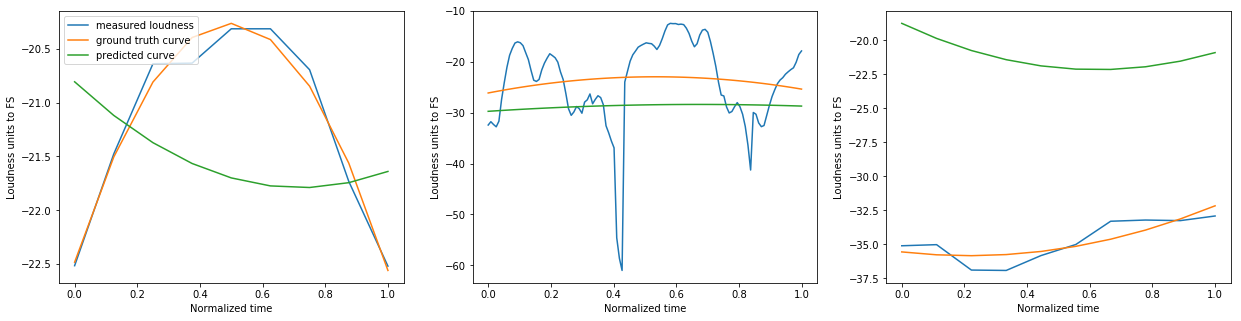

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(21, 5))

plt.subplot(131)
lvls, ytest, y = resultForIndex(11)
x = np.linspace(0, 1, len(lvls))
coefs = np.polyfit(x, lvls, 2)

ycalc = coefs[0]*x**2 + coefs[1]*x + coefs[2]
plt.plot(x, lvls, label='measured loudness')
plt.plot(x, ytest, label='ground truth curve')
plt.plot(x, y, label='predicted curve')
plt.ylabel('Loudness units to FS')
plt.xlabel('Normalized time')
plt.legend(loc='upper left')

plt.subplot(132)
lvls, ytest, y = resultForIndex(22)
x = np.linspace(0, 1, len(lvls))
coefs = np.polyfit(x, lvls, 2)

ycalc = coefs[0]*x**2 + coefs[1]*x + coefs[2]
plt.plot(x, lvls, label='measured loudness')
plt.plot(x, ytest, label='ground truth curve')
plt.plot(x, y, label='predicted curve')
plt.ylabel('Loudness units to FS')
plt.xlabel('Normalized time')

plt.subplot(133)
lvls, ytest, y = resultForIndex(33)
x = np.linspace(0, 1, len(lvls))
coefs = np.polyfit(x, lvls, 2)

ycalc = coefs[0]*x**2 + coefs[1]*x + coefs[2]
plt.plot(x, lvls, label='measured loudness')
plt.plot(x, ytest, label='ground truth curve')
plt.plot(x, y, label='predicted curve')
plt.ylabel('Loudness units to FS')
plt.xlabel('Normalized time')

plt.savefig('results/result')
plt.show()

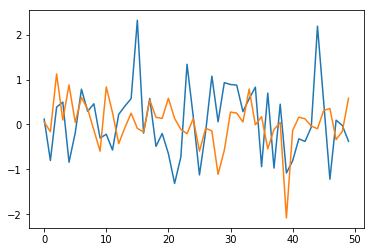

In [39]:
#  Plot a prediction and ground truth
from matplotlib.pyplot import plot

plt = plot(test[0:50,-3])
plot(pred[0:50, 0])


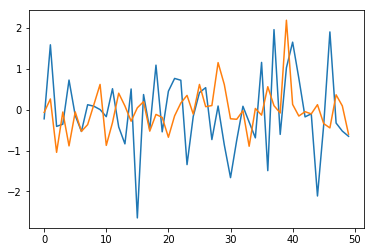

In [40]:
#  Plot a prediction and ground truth
from matplotlib.pyplot import plot
plt = plot(test[0:50,-2])
plot(pred[0:50, 1])


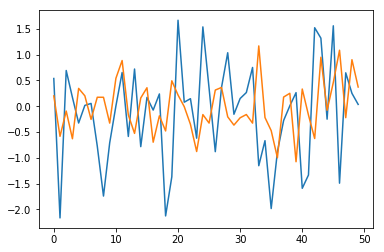

In [41]:
#  Plot a prediction and ground truth
from matplotlib.pyplot import plot
plt = plot(test[0:50,-1])
plot(pred[0:50, 2])